## Lighthill-Whitham-Richards Model
考虑连续 LWR 模型的 Cauchy 初值问题
\begin{equation*}
\begin{array}{cl}
\partial_t \rho(x,t)+ \partial_x \left( \rho(x,t) - \rho^2(x,t) \right) = 0, & \mathrm{for}\ x\in\mathbb{R},\ t>0 ,\\
\rho(x,0) = \rho_0(x), & \mathrm{for}\ x\in\mathbb{R},
\end{array}
\end{equation*}
其中 $0\leq \rho(x,t) \leq \rho_{\textnormal{max}} = 1$ 代表车流密度。用机器学习方法分别求解

1) 遇到交通堵塞（traffic jam）后的车流密度演化，其中初值条件取
\begin{equation*}
\rho_0(x) = 
\left\{\begin{array}{ll}
0.5,& \mathrm{for}\ x<0,\\
1,& \mathrm{for}\ x>0.\\
\end{array}\right.
\end{equation*}
2) 遇到绿灯放行（green light）后的车流密度演化，其中初值条件取
\begin{equation*}
\rho_0(x) = 
\left\{\begin{array}{ll}
1,& \mathrm{for}\ x<0,\\
0.5,& \mathrm{for}\ x>0.\\
\end{array}\right.
\end{equation*}

【参考资料】https://faculty.washington.edu/rjl/riemann_book/Traffic_flow.html

### 1.准备工作-调用函数库

In [67]:
import torch
print("torch version =", torch.__version__)
import torch.nn as nn
import numpy as np
import os
import time
import datetime
import argparse
import scipy.io as io
import math
import shutil
from torch import optim, autograd
from matplotlib import pyplot as plt
from torch.utils.data import Dataset, DataLoader
from itertools import cycle

torch version = 2.5.1


### 1.准备工作-FCNN

In [70]:
class FcBlock(nn.Module):
    """ 
        dim_in  -- dimension of each block's input data
        width   -- number of nodes in each block's hidden layer
        dim_out -- dimension of each block's output data (not the dimension of final output)  
    """
    
    def __init__(self, dim_in, width, dim_out):
        super(FcBlock, self).__init__()

        # set parameters
        self.dim_in = dim_in
        self.width = width
        self.dim_out = dim_out

        # create linear layers
        self.Linear1 = nn.Linear(dim_in, width)
        self.Linear2 = nn.Linear(width, dim_out)  
        # choose activation function = Tanh
        self.activation = nn.Tanh()      

    def forward(self, x):
        
        return self.activation(self.Linear2(self.activation(self.Linear1(x))))


class FcNet(nn.Module):
    """ 
        dim_in  -- dimension of each block's input data
        width   -- number of nodes in each block's hidden layer
        dim_out -- dimension of final output data   
    """

    def __init__(self, dim_in, width, dim_out, depth):
        super(FcNet, self).__init__()

        # set parameters
        self.dim_in = dim_in
        self.width = width
        self.dim_out = dim_out
        self.depth = depth

        # creat a list for holding all blocks/layers
        self.stack = nn.ModuleList()
                
        # input layer       
        self.stack.append(nn.Linear(dim_in, width))
        # add hidden blocks
        for i in range(depth):
            self.stack.append(FcBlock(width, width, width))        
        # output layer
        self.stack.append(nn.Linear(width, dim_out))  
        
    def forward(self, x):
        
        for layer in self.stack:
            x = layer(x)

        return x   

    def Xavier_initi(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.xavier_normal_(m.weight.data)
                if m.bias is not None:
                    m.bias.data.zero_()    

### 已知激波（traffic jam）

### 1.准备工作-训练和测试数据集

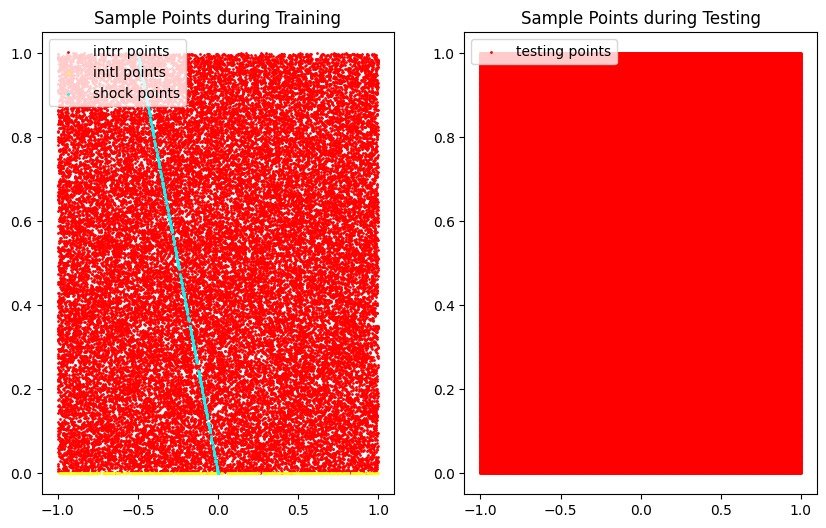

In [73]:
# computational domain
x_min, x_max = -1, 1
t_min, t_max = 0, 1

# number of collocation points for each part
traindata_size_intrr = 20000
traindata_size_initl = 501
traindata_size_bndry = 501
traindata_size_shock = 501

# generate testing points over the entire domain
x = torch.linspace(x_min, x_max, traindata_size_initl)
t = torch.linspace(t_min, t_max, traindata_size_bndry)
X, T = torch.meshgrid(x,t,indexing="ij") 
testdata = torch.squeeze(torch.stack([X.reshape(1,traindata_size_initl*traindata_size_bndry), T.reshape(1,traindata_size_initl*traindata_size_bndry)], dim=-1))   

# generate training points for each part
def SmpPts_Interior(num_intrr_pts):    
    """ num_intrr_pts = total number of sampling points inside the domain
        dim_prob  = dimension of sampling domain """
    
    # domain (-1,1) * (0,1)                
    temp0 = torch.rand(num_intrr_pts * 2, 1) * 2 - 1 
    temp1 = torch.rand(num_intrr_pts * 2, 1)
    X_intrr = torch.cat([temp0, temp1], dim=1)
    
    return X_intrr

def SmpPts_Initial(num_initl_pts):
    ''' num_initl_pts = total number of sampling points at initial time'''
    
    temp0 = torch.zeros(num_initl_pts, 1)
    X_initl = torch.cat([torch.rand(num_initl_pts, 1) * 2 -1, temp0], dim=1)
    
    return X_initl

def SmpPts_Shock(num_shock_pts, shock_speed):
    ''' num_shock_pts = number of sampling points for shock curve'''
    
    T_shock = torch.rand(num_shock_pts, 1)
    X_shock = shock_speed * T_shock
    XT_shock = torch.cat([X_shock, T_shock], dim=1)
    
    return XT_shock

smppts_intrr = SmpPts_Interior(traindata_size_intrr)
smppts_initl = SmpPts_Initial(traindata_size_initl)
smppts_shock = SmpPts_Shock(traindata_size_shock, -1/2)

fig = plt.figure(figsize=(10, 6), dpi= 100)
plt.subplot(1, 2, 1)
plt.scatter(smppts_intrr[:,0], smppts_intrr[:,1], c = 'red', label = 'intrr points', s=1)
plt.scatter(smppts_initl[:,0], smppts_initl[:,1], c = 'yellow', label = 'initl points', s=1)
plt.scatter(smppts_shock[:,0], smppts_shock[:,1], c = 'cyan', label = 'shock points', s=1)
plt.title('Sample Points during Training')
plt.legend(loc = 'upper left')

plt.subplot(1, 2, 2)
plt.scatter(testdata[:,0], testdata[:,1], c = 'red', label = 'testing points', s=1)
plt.title('Sample Points during Testing')
plt.legend(loc = 'upper left')
plt.show()

### 1.准备工作-升维函数在样本点处的值

In [84]:
# define auxiliary variable using modified Heaviside function 
def auxiliary_variable(x,t):
    '''  set a custom value 1 at the origin for Heaviside function '''
    
    temp = torch.ones(x.size(0))
    value = torch.heaviside(x + 1/2 * t, torch.squeeze(temp))
    
    return value

# compute the value of auxiliary variable for each input data point
smppts_intrr = torch.cat([smppts_intrr, auxiliary_variable(smppts_intrr[:,0], smppts_intrr[:,1]).reshape(-1,1)], dim=1)
smppts_initl = torch.cat([smppts_initl, auxiliary_variable(smppts_initl[:,0], smppts_initl[:,1]).reshape(-1,1)], dim=1)
smppts_test = torch.cat([testdata, auxiliary_variable(testdata[:,0], testdata[:,1]).reshape(-1,1)], dim=1)

# in particular, use mp0.0001 to achieve left and right limits along shock curve
smppts_shckL = torch.cat([smppts_shock, auxiliary_variable(smppts_shock[:,0] - 0.0001, smppts_shock[:,1]).reshape(-1,1)], dim=1)
smppts_shckR = torch.cat([smppts_shock, auxiliary_variable(smppts_shock[:,0] + 0.0001, smppts_shock[:,1]).reshape(-1,1)], dim=1)

# initial value and exact solution
def u_Exact_Initial(x):
    
    u0 = torch.ones(x.size(0))
    mask = x < 0
    u0[mask]= 1/2
    
    return u0

def u_Exact_Solution(x, t):
    
    u0 = u_Exact_Initial(x + t)
    mask = (x + 1/2 * t) < 0
    u0[mask] = 1/2

    return u0

### 2.网络训练

Done in 0:02:33.218895 !


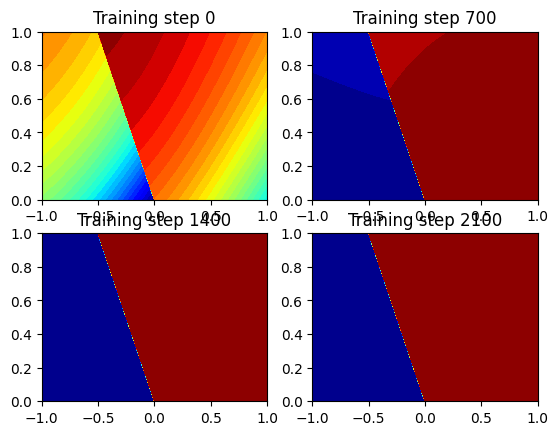

In [77]:
# penalty coefficient
beta = 400
# for decay of learning rate
milestones = [1000, 1600, 2000]

model = FcNet(3, 40, 1, 3)
model.Xavier_initi()

# create optimizer and learning rate schedular
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05, amsgrad=False)
schedular = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

since = time.time()
for i in range(2101):

    # enable computing gradients through autograd
    smppts_intrr.requires_grad = True 

    # compute values of initial condition
    u0_smppts = u_Exact_Initial(smppts_initl[:, 0])
    
    u_NN_intrr = model(smppts_intrr)
    u_NN_initl = model(smppts_initl)

    u_NN_shckL = model(smppts_shckL)
    u_NN_shckR = model(smppts_shckR) 

    # zero parameter gradients and then compute NN prediction of gradient u(x)
    model.zero_grad()
    gradu_NN_intrr = torch.autograd.grad(outputs=u_NN_intrr, inputs=smppts_intrr, grad_outputs=torch.ones_like(u_NN_intrr), retain_graph=True, create_graph=True, only_inputs=True)[0]

    # construct mini-batch loss function and then perform backward pass
    loss_intrr = torch.mean(torch.pow(gradu_NN_intrr[:,1] + torch.squeeze(u_NN_intrr) * gradu_NN_intrr[:,0], 2))
    loss_initl = torch.mean(torch.pow(torch.squeeze(u_NN_initl) - u0_smppts, 2))
    loss_shock = torch.mean(torch.pow(torch.squeeze(u_NN_shckR + u_NN_shckL) - 3/2, 2))

    loss_minibatch = loss_intrr + beta * (loss_initl + loss_shock)

    #zero parameter gradients
    optimizer.zero_grad()
    # backpropagation
    loss_minibatch.backward()
    # network parameter update
    optimizer.step()

    # plot the result as training progresses
    list_of_plots = []
    plt.rcdefaults()

    if i % 700 == 0: 
        ax = plt.subplot(2, 2, i // 700 + 1)
        
        u_test = model(smppts_test).detach()
        u_test = u_test.reshape(traindata_size_initl, traindata_size_bndry)    

        ax.contourf(X, T, u_test, 40, cmap = 'jet')        
        ax.set_title(f"Training step {i}")
        
        list_of_plots.append(ax)
    
time_elapsed = time.time() - since
print('Done in {}'.format(str(datetime.timedelta(seconds=time_elapsed))), '!')

### 3.计算结果

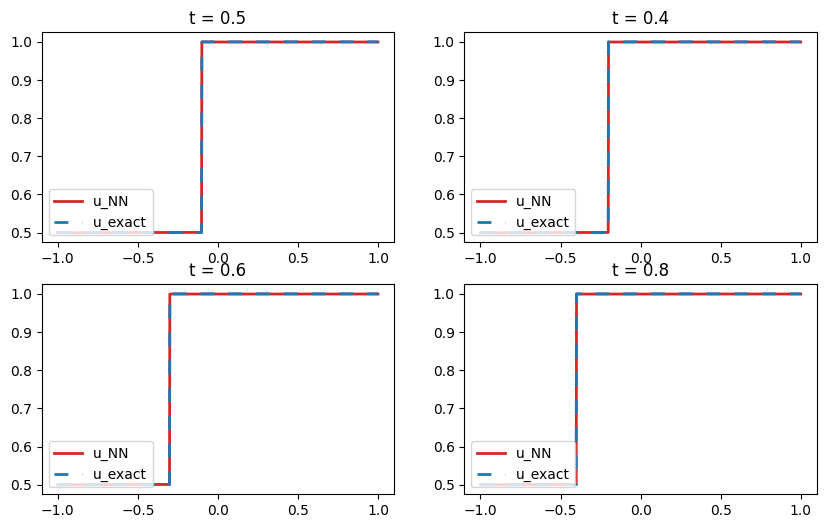

In [86]:
x = torch.linspace(x_min, x_max, steps = 1001)
t = torch.ones(x.size())

# plot the solution at t = 0.2
u_exact = u_Exact_Solution(x, 0.2 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.2 * t.reshape(-1, 1)], dim=1)
test_smppts = torch.cat([test_smppts, auxiliary_variable(test_smppts[:, 0], test_smppts[:, 1]).reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

fig = plt.figure(figsize=(10, 6), dpi= 100)
plt.subplot(2, 2, 1)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.2')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.4
u_exact = u_Exact_Solution(x, 0.4 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.4 * t.reshape(-1, 1)], dim=1)
test_smppts = torch.cat([test_smppts, auxiliary_variable(test_smppts[:, 0], test_smppts[:, 1]).reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 2)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.4')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.6
u_exact = u_Exact_Solution(x, 0.6 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.6 * t.reshape(-1, 1)], dim=1)
test_smppts = torch.cat([test_smppts, auxiliary_variable(test_smppts[:, 0], test_smppts[:, 1]).reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 3)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.6')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.8
u_exact = u_Exact_Solution(x, 0.8 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.8 * t.reshape(-1, 1)], dim=1)
test_smppts = torch.cat([test_smppts, auxiliary_variable(test_smppts[:, 0], test_smppts[:, 1]).reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 4)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.8')
plt.legend(loc = 'lower left')

### 稀疏波（Green light）

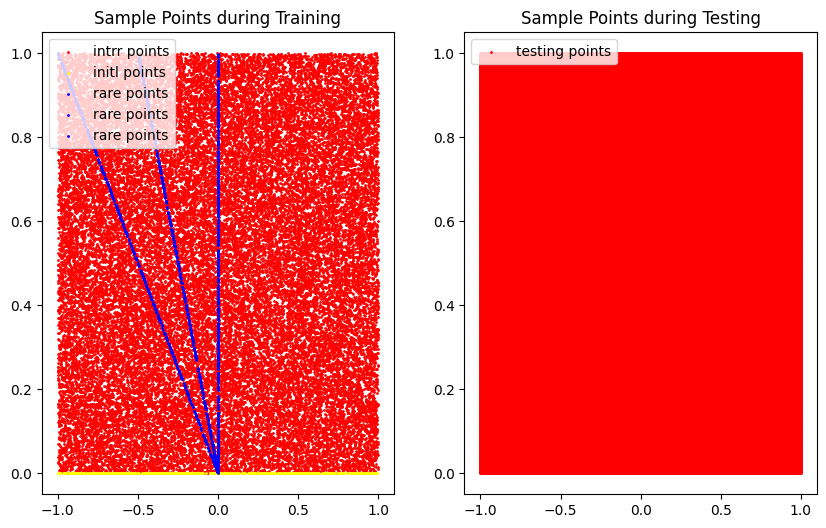

In [185]:
def SmpPts_Rare(num_rare_pts):
    ''' num_rare_pts = number of sampling points for rarewave boundary'''
    
    T_rare = torch.rand(num_rare_pts, 1)
    X_rare = 0 * T_rare
    XT_rare = torch.cat([X_rare, T_rare], dim=1)
    
    return XT_rare

def SmpPts_Rare_2(num_rare_pts):
    
    T_rare = torch.rand(num_rare_pts, 1)
    X_rare = -1 * T_rare
    XT_rare = torch.cat([X_rare, T_rare], dim=1)
    
    return XT_rare

def SmpPts_Rare_3(num_rare_pts):
    
    T_rare = torch.rand(num_rare_pts, 1)
    X_rare = -1/2 * T_rare
    XT_rare = torch.cat([X_rare, T_rare], dim=1)
    
    return XT_rare

# computational domain
x_min, x_max = -1, 1
t_min, t_max = 0, 1

# number of collocation points for each part
traindata_size_intrr = 20000
traindata_size_initl = 501
traindata_size_bndry = 501
traindata_size_rare = 501

# generate testing points over the entire domain
x = torch.linspace(x_min, x_max, traindata_size_initl)
t = torch.linspace(t_min, t_max, traindata_size_bndry)
X, T = torch.meshgrid(x,t,indexing="ij") 
testdata = torch.squeeze(torch.stack([X.reshape(1,traindata_size_initl*traindata_size_bndry), T.reshape(1,traindata_size_initl*traindata_size_bndry)], dim=-1))   

smppts_intrr = SmpPts_Interior(traindata_size_intrr)
smppts_initl = SmpPts_Initial(traindata_size_initl)
smppts_rare = SmpPts_Rare(traindata_size_rare)
smppts_rare_2 = SmpPts_Rare_2(traindata_size_rare)
smppts_rare_3 = SmpPts_Rare_3(traindata_size_rare)

smppts_test = testdata

fig = plt.figure(figsize=(10, 6), dpi= 100)
plt.subplot(1, 2, 1)
plt.scatter(smppts_intrr[:,0], smppts_intrr[:,1], c = 'red', label = 'intrr points', s=1)
plt.scatter(smppts_initl[:,0], smppts_initl[:,1], c = 'yellow', label = 'initl points', s=1)
plt.scatter(smppts_rare[:,0], smppts_rare[:,1], c = 'blue', label = 'rare points', s=1)
plt.scatter(smppts_rare_2[:,0], smppts_rare_2[:,1], c = 'blue', label = 'rare points', s=1)
plt.scatter(smppts_rare_3[:,0], smppts_rare_3[:,1], c = 'blue', label = 'rare points', s=1)
plt.title('Sample Points during Training')
plt.legend(loc = 'upper left')

plt.subplot(1, 2, 2)
plt.scatter(testdata[:,0], testdata[:,1], c = 'red', label = 'testing points', s=1)
plt.title('Sample Points during Testing')
plt.legend(loc = 'upper left')
plt.show()

# initial value and exact solution
def u_Exact_Initial(x):
    
    u0 = torch.ones(x.size(0))
    mask = x > 0
    u0[mask]= 1/2
    
    return u0

def u_Exact_Solution(x, t):
    
    u0 = torch.ones(x.size(0))
    mask1 = (x + t) <= 0
    mask2 = x > 0
    u0 = 1/2 * (1 - x/t)
    u0[mask1] = 1
    u0[mask2] = 1/2

    return u0

Done in 0:02:31.928099 !


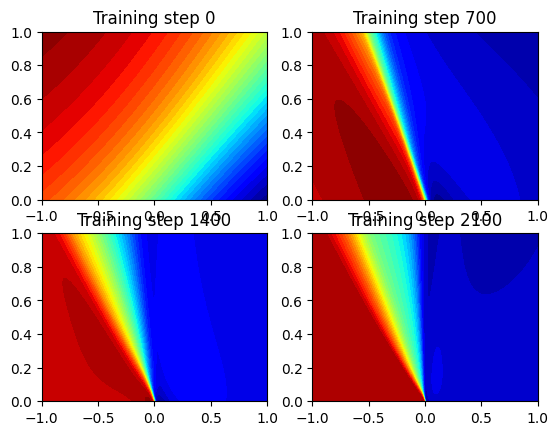

In [187]:
# penalty coefficient
beta = 400
# for decay of learning rate
milestones = [1000, 1600, 2000]

model = FcNet(2, 40, 1, 3)
model.Xavier_initi()

# create optimizer and learning rate schedular
optimizer = torch.optim.AdamW(model.parameters(), lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05, amsgrad=False)
schedular = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

since = time.time()
for i in range(2101):

    # enable computing gradients through autograd
    smppts_intrr.requires_grad = True 

    # compute values of initial condition
    u0_smppts = u_Exact_Initial(smppts_initl[:, 0])
    
    u_NN_intrr = model(smppts_intrr)
    u_NN_initl = model(smppts_initl)
    u_NN_rare = model(smppts_rare)
    u_NN_rare_2 = model(smppts_rare_2)
    u_NN_rare_3 = model(smppts_rare_3)
    
    # zero parameter gradients and then compute NN prediction of gradient u(x)
    model.zero_grad()
    gradu_NN_intrr = torch.autograd.grad(outputs=u_NN_intrr, inputs=smppts_intrr, grad_outputs=torch.ones_like(u_NN_intrr), retain_graph=True, create_graph=True, only_inputs=True)[0]

    # construct mini-batch loss function and then perform backward pass
    loss_intrr = torch.mean(torch.pow(gradu_NN_intrr[:,1] + torch.squeeze(u_NN_intrr) * gradu_NN_intrr[:,0], 2))
    loss_initl = torch.mean(torch.pow(torch.squeeze(u_NN_initl) - u0_smppts, 2))
    loss_rare = torch.mean(torch.pow(torch.squeeze(u_NN_rare) - 1/2, 2))
    loss_rare2 = torch.mean(torch.pow(torch.squeeze(u_NN_rare_2) - 1, 2))
    loss_rare3 = torch.mean(torch.pow(torch.squeeze(u_NN_rare_3) - 3/4, 2))

    loss_minibatch = loss_intrr + beta * (loss_initl + loss_rare + loss_rare2 + loss_rare3)

    #zero parameter gradients
    optimizer.zero_grad()
    # backpropagation
    loss_minibatch.backward()
    # network parameter update
    optimizer.step()

    # plot the result as training progresses
    list_of_plots = []
    plt.rcdefaults()

    if i % 700 == 0: 
        ax = plt.subplot(2, 2, i // 700 + 1)
        
        u_test = model(smppts_test).detach()
        u_test = u_test.reshape(traindata_size_initl, traindata_size_bndry)    

        ax.contourf(X, T, u_test, 40, cmap = 'jet')        
        ax.set_title(f"Training step {i}")
        
        list_of_plots.append(ax)
    
time_elapsed = time.time() - since
print('Done in {}'.format(str(datetime.timedelta(seconds=time_elapsed))), '!')

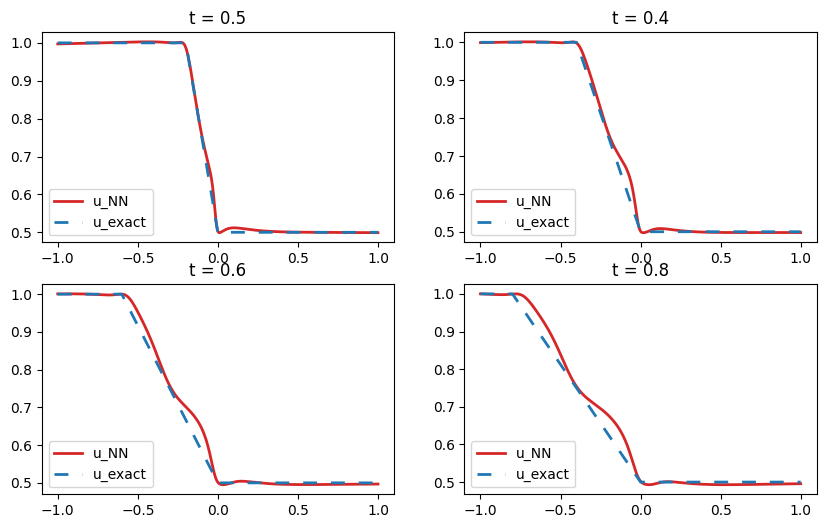

In [189]:
x = torch.linspace(x_min, x_max, steps = 1001)
t = torch.ones(x.size())

# plot the solution at t = 0.2
u_exact = u_Exact_Solution(x, 0.2 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.2 * t.reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

fig = plt.figure(figsize=(10, 6), dpi= 100)
plt.subplot(2, 2, 1)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.5')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.4
u_exact = u_Exact_Solution(x, 0.4 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.4 * t.reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 2)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.4')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.6
u_exact = u_Exact_Solution(x, 0.6 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.6 * t.reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 3)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.6')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.8
u_exact = u_Exact_Solution(x, 0.8 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.8 * t.reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 4)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.8')
plt.legend(loc = 'lower left')

### 未知激波（traffic jam）

In [192]:
# computational domain
x_min, x_max = -1, 1
t_min, t_max = 0, 1

# number of collocation points for each part
traindata_size_intrr = 20000
traindata_size_initl = 501
traindata_size_bndry = 501
traindata_size_shock = 501

# generate testing points over the entire domain
x = torch.linspace(x_min, x_max, traindata_size_initl)
t = torch.linspace(t_min, t_max, traindata_size_bndry)
X, T = torch.meshgrid(x,t,indexing="ij") 
testdata = torch.squeeze(torch.stack([X.reshape(1,traindata_size_initl*traindata_size_bndry), T.reshape(1,traindata_size_initl*traindata_size_bndry)], dim=-1))   

# generate training points for each part
def SmpPts_Interior(num_intrr_pts):    
    """ num_intrr_pts = total number of sampling points inside the domain
        dim_prob  = dimension of sampling domain """
    
    # domain (-1,1) * (0,1)                
    X_intrr = torch.rand(num_intrr_pts * 2, 1) * 2 - 1 
    T_intrr = torch.rand(num_intrr_pts * 2, 1)
    XT_intrr = torch.cat([X_intrr, T_intrr], dim=1)
    
    return XT_intrr

def SmpPts_Initial(num_initl_pts):
    ''' num_initl_pts = total number of sampling points at initial time'''
    
    T_initl = torch.zeros(num_initl_pts, 1)
    XT_initl = torch.cat([torch.rand(num_initl_pts, 1) * 2 -1, T_initl], dim=1)
    
    return XT_initl

smppts_intrr = SmpPts_Interior(traindata_size_intrr)
smppts_initl = SmpPts_Initial(traindata_size_initl)

In [194]:
def SmpPts_Shock(num_shock_pts, shock_speed):
    ''' num_shock_pts = number of sampling points for shock curve'''
    
    T_shock = torch.rand(num_shock_pts, 1)
    X_shock = shock_speed * T_shock
    XT_shock = torch.cat([X_shock, T_shock], dim=1)
    
    return XT_shock

# define augmented variable using modified Heaviside function 
def augmented_variable(x, t, shock_speed):
    '''  set a custom value 1 at the origin for Heaviside function '''
    
    temp = torch.ones(x.size(0))
    value = torch.heaviside(x - shock_speed * t, torch.squeeze(temp))
    
    return value

# initial value and exact solution
def u_Exact_Initial(x):
    
    u0 = torch.ones(x.size(0))
    mask = x < 0
    u0[mask]= 0.5
    
    return u0

def u_Exact_Solution(x, t):
    
    return u_Exact_Initial(x + 1/2 * t)

Done in 0:02:06.147886 !


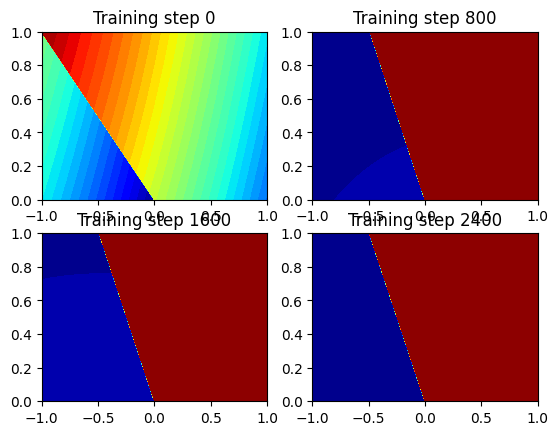

In [203]:
# penalty coefficient
beta = 400
# for decay of learning rate
milestones = [1500, 2000, 2500, 2800]

model = FcNet(3, 60, 1, 1)
model.Xavier_initi()

# initial guess of shock speed, true value is -1/2 for this example
shock_speed_parameter = torch.nn.Parameter(-1 * torch.ones(1, requires_grad=True))
hist_shock_speed = []

# create optimizer and learning rate schedular
optimizer = torch.optim.AdamW(list(model.parameters())+[shock_speed_parameter], lr=0.01, betas=(0.9, 0.999), eps=1e-08, weight_decay=0.05, amsgrad=False)
schedular = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones, gamma=0.1)

since = time.time()
for i in range(2401):

    # save the value of shock speed at current iteration
    hist_shock_speed.append(shock_speed_parameter.item())

    shock_speed = torch.squeeze(shock_speed_parameter.detach())
    # update collocation points along shock curve
    smppts_shock = SmpPts_Shock(traindata_size_shock, shock_speed)
    
    # append the value of auxiliary variable for each input data point
    smppts_intrr_updated = torch.cat([smppts_intrr, augmented_variable(smppts_intrr[:,0], smppts_intrr[:,1], shock_speed).reshape(-1,1)], dim=1)
    smppts_initl_updated = torch.cat([smppts_initl, augmented_variable(smppts_initl[:,0], smppts_initl[:,1], shock_speed).reshape(-1,1)], dim=1)
    smppts_test_updated = torch.cat([testdata, augmented_variable(testdata[:,0], testdata[:,1], shock_speed).reshape(-1,1)], dim=1)
    # in particular, use mp0.0001 to achieve left and right limits along shock curve
    smppts_shckL_updated = torch.cat([smppts_shock, augmented_variable(smppts_shock[:,0] - 0.0001, smppts_shock[:,1], shock_speed).reshape(-1,1)], dim=1)
    smppts_shckR_updated = torch.cat([smppts_shock, augmented_variable(smppts_shock[:,0] + 0.0001, smppts_shock[:,1], shock_speed).reshape(-1,1)], dim=1)

    # enable computing gradients through autograd
    smppts_intrr_updated.requires_grad = True 

    # compute values of initial condition
    u0_smppts = u_Exact_Initial(smppts_initl_updated[:, 0])
    
    u_NN_intrr = model(smppts_intrr_updated)
    u_NN_initl = model(smppts_initl_updated)

    u_NN_shckL = model(smppts_shckL_updated)
    u_NN_shckR = model(smppts_shckR_updated) 

    # zero parameter gradients and then compute NN prediction of gradient u(x)
    model.zero_grad()
    gradu_NN_intrr = torch.autograd.grad(outputs=u_NN_intrr, inputs=smppts_intrr_updated, grad_outputs=torch.ones_like(u_NN_intrr), retain_graph=True, create_graph=True, only_inputs=True)[0]

    # construct mini-batch loss function and then perform backward pass
    loss_intrr = torch.mean(torch.pow(gradu_NN_intrr[:,1] + torch.squeeze(u_NN_intrr) * gradu_NN_intrr[:,0], 2))
    loss_initl = torch.mean(torch.pow(torch.squeeze(u_NN_initl) - u0_smppts, 2))
    loss_shock = torch.mean(torch.pow(1 - torch.squeeze(u_NN_shckR + u_NN_shckL) - shock_speed_parameter, 2))

    loss_minibatch = loss_intrr + beta * (loss_initl + loss_shock)

    #zero parameter gradients
    optimizer.zero_grad()
    # backpropagation
    loss_minibatch.backward()
    # network parameter update
    optimizer.step()

    # plot the result as training progresses
    list_of_plots = []
    plt.rcdefaults()

    if i % 800 == 0: 
        ax = plt.subplot(2, 2, i // 800 + 1)
        
        u_test = model(smppts_test_updated).detach()
        u_test = u_test.reshape(traindata_size_initl, traindata_size_bndry)    

        ax.contourf(X, T, u_test, 40, cmap = 'jet')        
        ax.set_title(f"Training step {i}")
        
        list_of_plots.append(ax)
    
time_elapsed = time.time() - since
print('Done in {}'.format(str(datetime.timedelta(seconds=time_elapsed))), '!')

Approximate Shock Speed = -0.4935419 (differing from the exact value by a relative error of 149.35%)


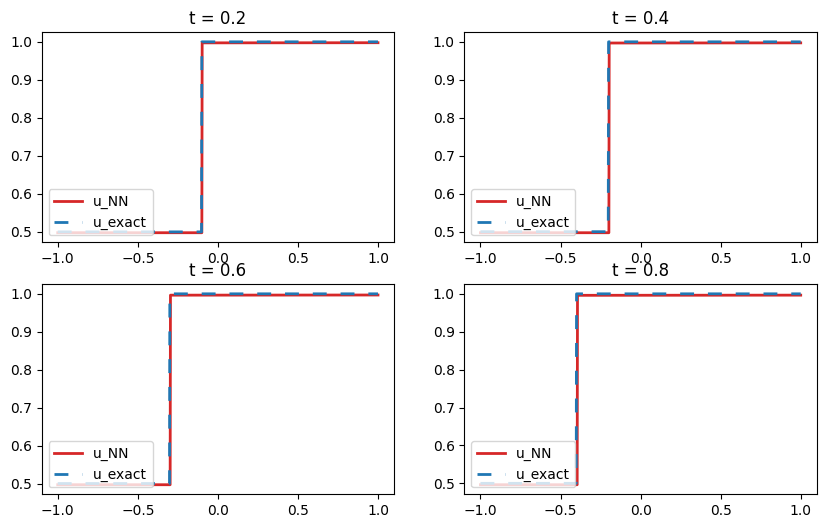

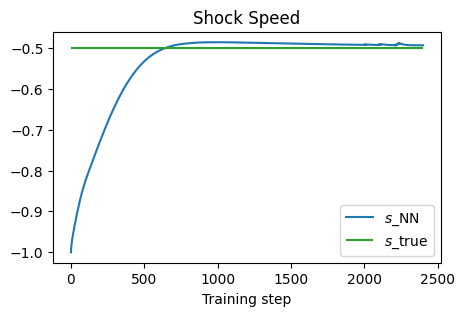

In [207]:
print('Approximate Shock Speed =', shock_speed.numpy(), '(differing from the exact value by a relative error of', '{:.2%})'.format(abs(shock_speed-1)))

x = torch.linspace(x_min, x_max, steps = 1001)
t = torch.ones(x.size())

# plot the solution at t = 0.2
u_exact = u_Exact_Solution(x, 0.2 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.2 * t.reshape(-1, 1)], dim=1)
test_smppts = torch.cat([test_smppts, augmented_variable(test_smppts[:, 0], test_smppts[:, 1], shock_speed).reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

fig = plt.figure(figsize=(10, 6), dpi= 100)
plt.subplot(2, 2, 1)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.2')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.4
u_exact = u_Exact_Solution(x, 0.4 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.4 * t.reshape(-1, 1)], dim=1)
test_smppts = torch.cat([test_smppts, augmented_variable(test_smppts[:, 0], test_smppts[:, 1], shock_speed).reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 2)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.4')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.6
u_exact = u_Exact_Solution(x, 0.6 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.6 * t.reshape(-1, 1)], dim=1)
test_smppts = torch.cat([test_smppts, augmented_variable(test_smppts[:, 0], test_smppts[:, 1], shock_speed).reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 3)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.6')
plt.legend(loc = 'lower left')

# plot the solution at t = 0.8
u_exact = u_Exact_Solution(x, 0.8 * t)
test_smppts = torch.cat([x.reshape(-1, 1), 0.8 * t.reshape(-1, 1)], dim=1)
test_smppts = torch.cat([test_smppts, augmented_variable(test_smppts[:, 0], test_smppts[:, 1], shock_speed).reshape(-1, 1)], dim=1)
u_pred = model(test_smppts)

plt.subplot(2, 2, 4)
plt.plot(x, u_pred.detach(), linewidth=2.0, label="u_NN", color="tab:red")
plt.plot(x, u_exact, linestyle='dashed', dashes=(5, 5), linewidth=2.0, label="u_exact", color="tab:blue")
plt.title('t = 0.8')
plt.legend(loc = 'lower left')

fig = plt.figure(figsize=(5, 3), dpi= 100)
plt.title(r"Shock Speed")
plt.plot(hist_shock_speed, label=r"$s$_NN")
plt.hlines(-1/2, 0, len(hist_shock_speed), label=r"$s$_true", color="tab:green")
plt.legend()
plt.xlabel("Training step")
plt.show()